# Prototype: delta

| Properties      | Data    |
|---------------|-----------|
| *Labels* | `['BENIGN', 'DDoS']` |
| *Normalization* | `Min-Max` |
| *Sample Size* | `10.000`|
| *Adversarial Attack* | `CW` |
| *Explanations* | `SHAP` |


---

## *Has to be run first alone!*

In [1]:
# To import modules from the functions directory
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

## Data Preprocessing

In [2]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

encoding_type = 0 # binary encoding
norm_type = 0 # min-max normalization
label_names = ['BENIGN', 'DDoS'] # labels to include
sample_size = 5000 # sample size for each label -> 2 x sample_size = total samples

dataset = dp.build_dataset(label_names)

normalizer, zero_columns = dp.generate_normalizer(dataset, norm_type)

feature_df, label_df, used_indices = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size=sample_size, random_sample_state=42)
print(label_df.value_counts()) # -> will first show [0, 1] then [1, 0] if label number is equal

-- Building CICIDS2017 dataset --
--- Combining all CICIDS2017 files ---
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Wednesday-workingHours.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
--- Removing NaN and Infinity values ---
Removing 1358 Rows with NaN values
Removing 1509 Rows with Infinity values
--- Extracting labels ---
 Label
BENIGN    2271320
DDoS       128025
Name: count, dtype: int64
-- Generating normalizer --
--- Splitting labels and features ---
Zero Columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (10000, 79)
--- Splitti

## Split Data

In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 70) (2000, 70) (8000, 2) (2000, 2)


## Create IDS

In [100]:
import functions.intrusion_detection_system as ids
import importlib
importlib.reload(ids)

# build ids with complete dataset
ids_model = ids.build_intrusion_detection_system(X_train, y_train, X_test, y_test)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8144 - loss: 0.5964 - val_accuracy: 0.9775 - val_loss: 0.2770
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9747 - loss: 0.1938 - val_accuracy: 0.9812 - val_loss: 0.0661
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9803 - loss: 0.0637 - val_accuracy: 0.9837 - val_loss: 0.0508
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9827 - loss: 0.0506 - val_accuracy: 0.9856 - val_loss: 0.0433
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9834 - loss: 0.0445 - val_accuracy: 0.9856 - val_loss: 0.0378
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9835 - loss: 0.0412 - val_accuracy: 0.9862 - val_loss: 0.0341
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9843 - loss: 0.0384 - val_accuracy: 0.9881 - val_loss: 0.0323
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9847 - loss: 0.0367 - val_accuracy: 0.9887 - val_loss:

2025-03-14 17:18:02.431034: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


## Generate Attacks

In [5]:
import functions.attack_generator as ag
import importlib
import numpy as np
importlib.reload(ag)

all_features = dataset.drop(columns=[' Label'])
art_model = ag.convert_to_art_model(ids_model, X_train) # TODO: use all features for generating art model

# create smaller dataset
X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

target_label = np.zeros_like(y_train)
target_label[:, 0] = 1 # desired predicted label = [1, 0] = BENIGN
# print(target_label[:3])

import multiprocessing
num_cores = multiprocessing.cpu_count()

X_adv = ag.generate_cw_attacks_parallel(art_model, X_train, target_label=target_label, num_cores=num_cores)

y_pred_adv = ag.evaluate_art_model(art_model, X_adv, y_train)
print(y_pred_adv.shape)

(8000, 70) (2000, 70) (8000, 2) (2000, 2)
Running attack using 24 CPU cores...

Process 89142 is generating adversarial examples for batch of size 333 
Process 89143 is generating adversarial examples for batch of size 333 
Process 89145 is generating adversarial examples for batch of size 333 
Process 89144 is generating adversarial examples for batch of size 333 
Process 89146 is generating adversarial examples for batch of size 333 


Process 89147 is generating adversarial examples for batch of size 333 


Process 89148 is generating adversarial examples for batch of size 333 


Process 89149 is generating adversarial examples for batch of size 333 

Process 89150 is generating adversarial examples for batch of size 333 

Process 89152 is generating adversarial examples for batch of size 333 
Process 89151 is generating adversarial examples for batch of size 333 
Process 89153 is generating adversarial examples for batch of size 333 


Process 89155 is generating adversarial exampl

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/341 [00:00<?, ?it/s]

Accuracy: 76.02%
              precision    recall  f1-score   support

      BENIGN       0.68      1.00      0.81      3988
      ATTACK       1.00      0.52      0.69      4012

   micro avg       0.76      0.76      0.76      8000
   macro avg       0.84      0.76      0.75      8000
weighted avg       0.84      0.76      0.75      8000
 samples avg       0.76      0.76      0.76      8000

Confusion Matrix: Positive == BENIGN
TN: 2094, FP: 1918, FN: 0, TP: 3988
(8000, 2)


In [6]:
# convert y values
y_pred = ids_model.predict(X_train)
y_pred = (y_pred > 0.5)
y_pred_binary = np.array(y_pred).argmin(axis=1) # 1 == BENIGN, 0 == MALICIOUS
y_pred_adv_binary = np.array(y_pred_adv).argmin(axis=1)
y_train_binary = np.array(y_train).argmin(axis=1)

print(y_pred_binary.shape, y_pred_adv_binary.shape, y_train_binary.shape)

  1/250 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
(8000,) (8000,) (8000,)


In [7]:
# find correctly classified samples
correctly_benign_classified_indices = np.where((y_train_binary == 1) & (y_pred_binary == 1))[0]
print(f"Correctly classified as BENIGN from the IDS: {len(correctly_benign_classified_indices)}")
misclassified_as_benign_due_attack_indices = np.where((y_train_binary == 0) & (y_pred_binary == 0) & (y_pred_adv_binary == 1))[0]
print(f"ATTACK sample misclassified as BENIGN due to adversarial attack: {len(misclassified_as_benign_due_attack_indices)}")

Correctly classified as BENIGN from the IDS: 3878
ATTACK sample misclassified as BENIGN due to adversarial attack: 1913


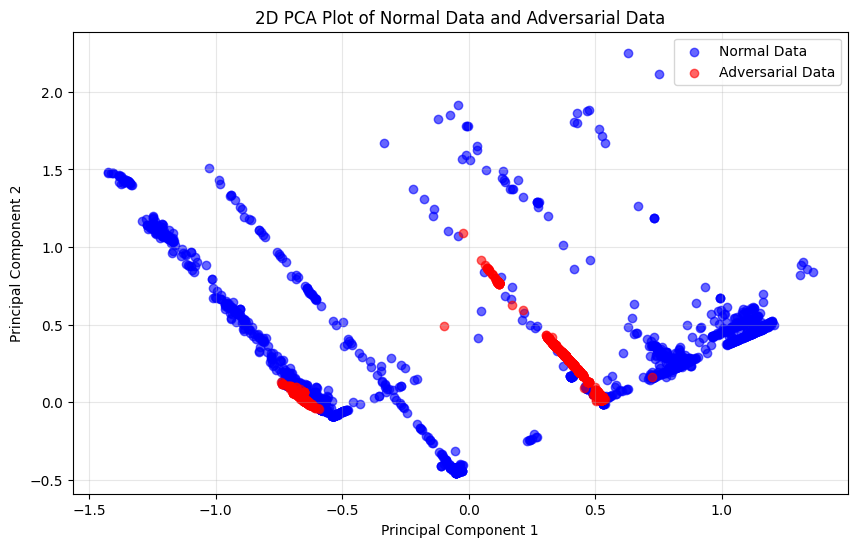

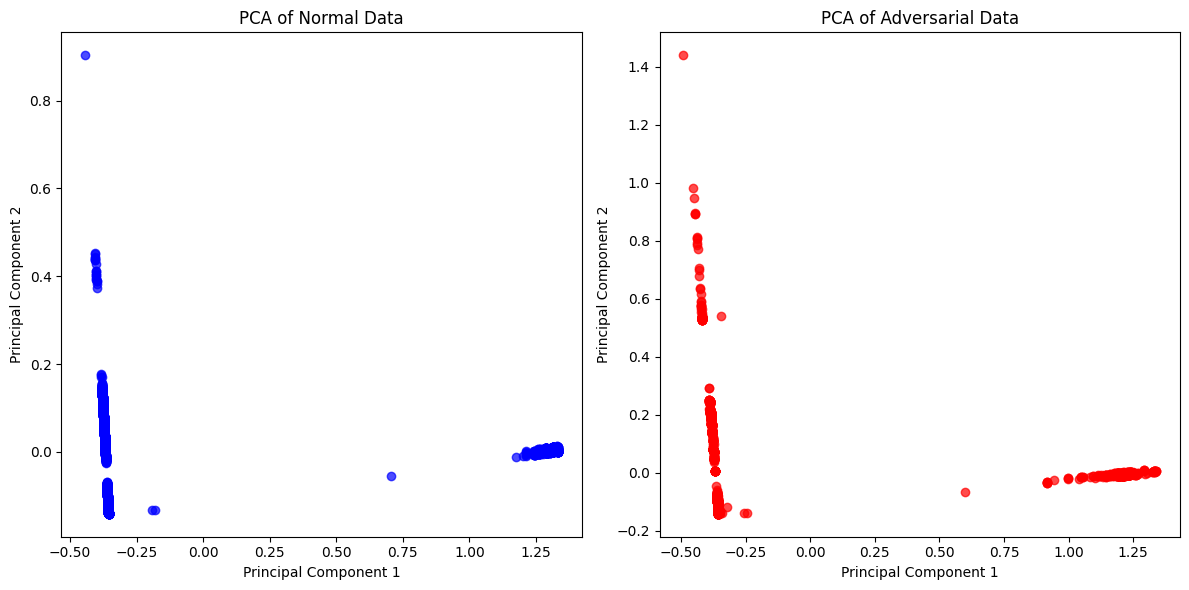

In [8]:
import functions.visualizer as visualizer
import importlib
importlib.reload(visualizer)

visualizer.visualize_data_distribution(X_train.iloc[correctly_benign_classified_indices], 'Normal Data', X_adv.iloc[misclassified_as_benign_due_attack_indices], 'Adversarial Data')
visualizer.pca_visualization_side_by_side(X_train.iloc[misclassified_as_benign_due_attack_indices], 'Normal Data', X_adv.iloc[misclassified_as_benign_due_attack_indices], 'Adversarial Data')

## Explainer

In [9]:
import functions.explainer as exp
import importlib
importlib.reload(exp)

explainer = exp.generate_shap_explainer(ids_model, X_train)

shap_values, shap_values_df = exp.generate_shap_values(explainer, X_train)
print(shap_values_df.shape)

shap_values_adv, shap_values_adv_df = exp.generate_shap_values(explainer, X_adv)
print(shap_values_adv_df.shape)

PermutationExplainer explainer: 8001it [04:12, 30.86it/s]                          


(8000, 70)


PermutationExplainer explainer: 8001it [04:15, 30.15it/s]                          


(8000, 70)


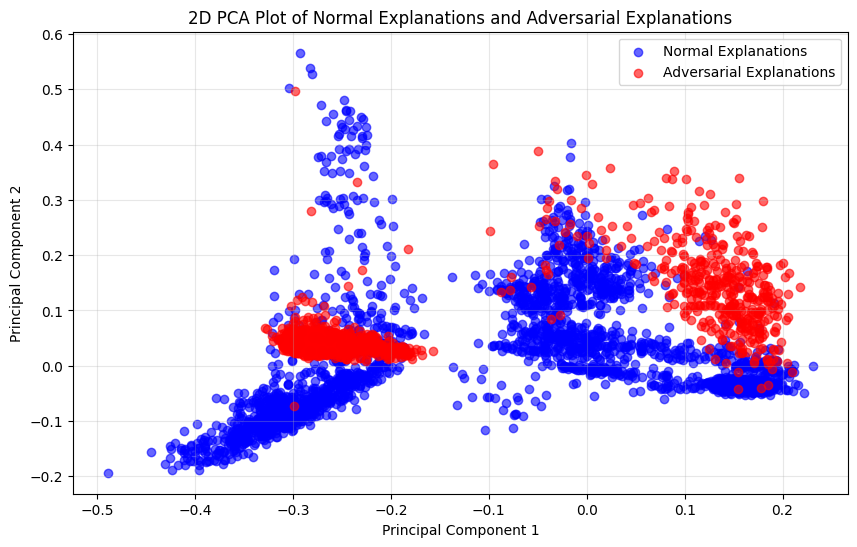

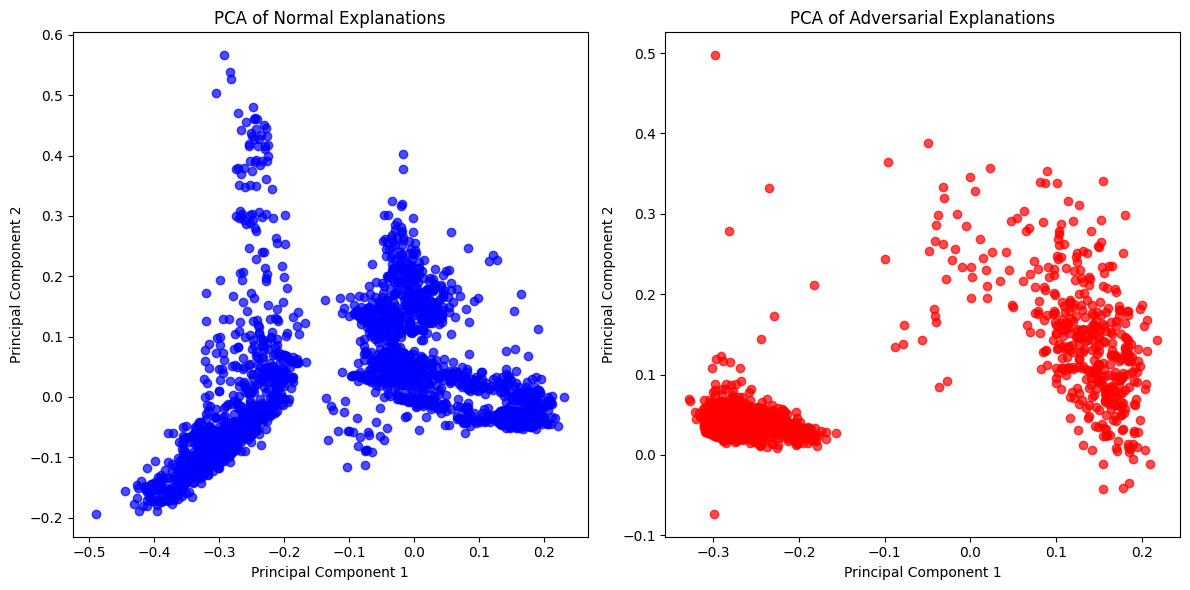

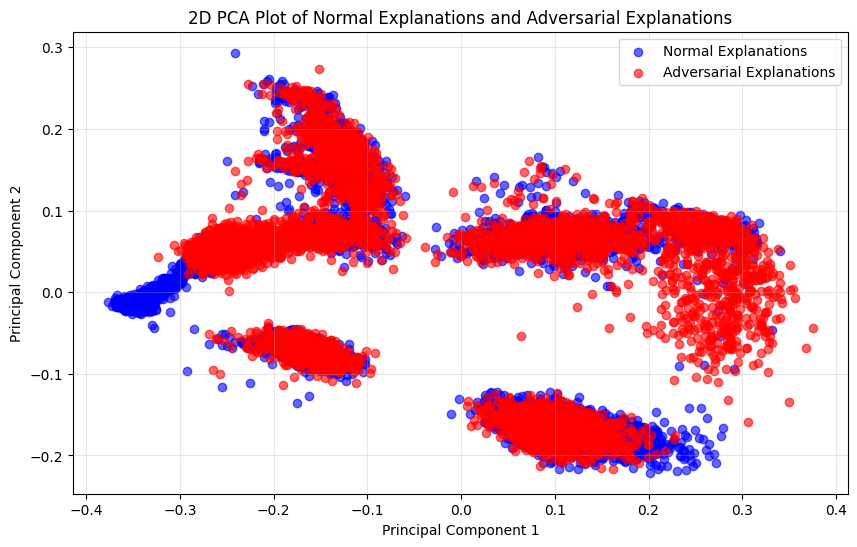

In [10]:
visualizer.visualize_data_distribution(shap_values_df.iloc[correctly_benign_classified_indices], 'Normal Explanations', shap_values_adv_df.iloc[misclassified_as_benign_due_attack_indices], 'Adversarial Explanations')
visualizer.pca_visualization_side_by_side(shap_values_df.iloc[correctly_benign_classified_indices], 'Normal Explanations', shap_values_adv_df.iloc[misclassified_as_benign_due_attack_indices], 'Adversarial Explanations')
visualizer.visualize_data_distribution(shap_values_df, 'Normal Explanations', shap_values_adv_df, 'Adversarial Explanations')

(8000, 70) (8000, 70)


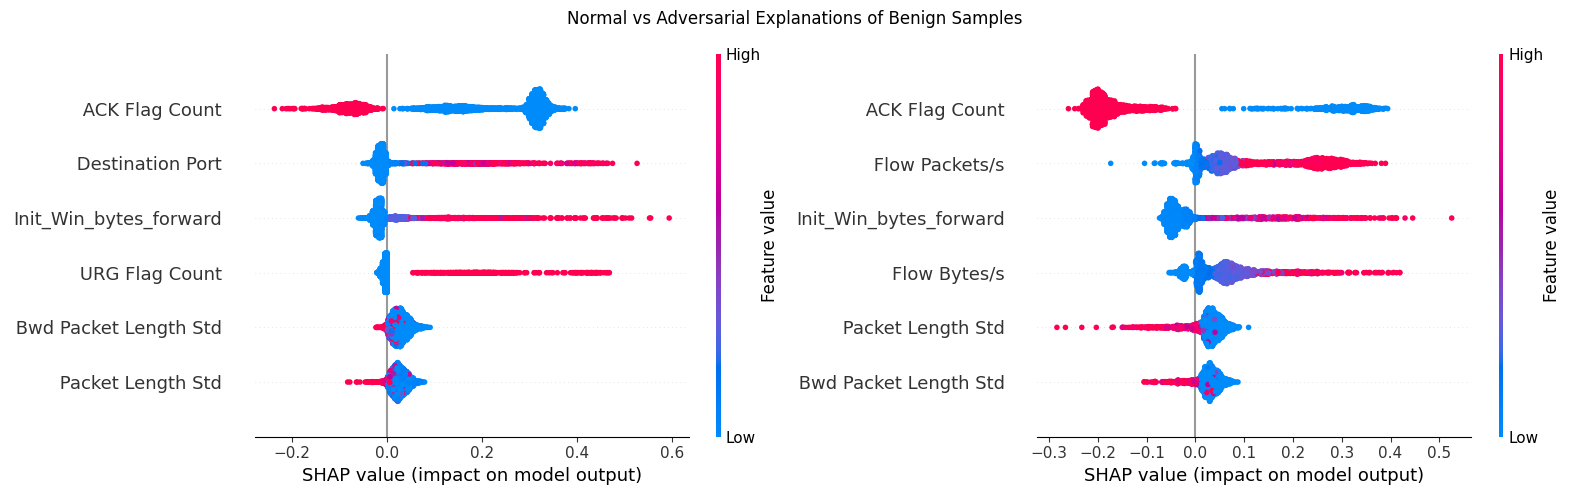

In [11]:
print(shap_values.shape, X_train.shape)
exp.plot_shap_summary_comparison(shap_values[correctly_benign_classified_indices], X_train.iloc[correctly_benign_classified_indices], shap_values_adv[misclassified_as_benign_due_attack_indices], X_adv.iloc[misclassified_as_benign_due_attack_indices], 6, title='Normal vs Adversarial Explanations of Benign Samples')

## Detector

In [12]:
import functions.detector as det
import importlib
importlib.reload(det)

# create dataframe
X, y = det.build_train_datasets(shap_values_df.iloc[correctly_benign_classified_indices], shap_values_adv_df.iloc[misclassified_as_benign_due_attack_indices])
print(X.shape, y.shape)

# split data
X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X, y, test_size=0.1, random_state=1503)
print(X_train_det.shape, X_test_det.shape, y_train_det.shape, y_test_det.shape)

# build detector
detector = det.build_detector(X_train_det, y_train_det, X_test_det, y_test_det)

(5791, 70) (5791, 2)
(5211, 70) (580, 70) (5211, 2) (580, 2)
Epoch 1/10


2025-03-14 15:23:50.219576: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7537 - loss: 0.6727 - val_accuracy: 0.9089 - val_loss: 0.5710
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8665 - loss: 0.5262 - val_accuracy: 0.9338 - val_loss: 0.2964
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9230 - loss: 0.2892 - val_accuracy: 0.9722 - val_loss: 0.1128
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9698 - loss: 0.1377 - val_accuracy: 0.9827 - val_loss: 0.0588
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0847 - val_accuracy: 0.9818 - val_loss: 0.0449
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9796 - loss: 0.0601 - val_accuracy: 0.9856 - val_loss: 0.0408
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0504 - val_accuracy: 0.9866 - val_loss: 0.0397
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0459 - val_accuracy: 0.9866 - val_loss: 0.0391
Epo

---
## Evaluation - On New Samples

In [13]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

# exclude previously used samples
dataset_excluded = dataset.drop(index=used_indices)

X_eval, y_eval, used_eval_indices = dp.preprocess_data(dataset_excluded, encoding_type, normalizer, zero_columns, sample_size=200, random_sample_state=17)
print(y_eval.value_counts())

# TODO: use two different datasets and perform attacks only on one of them -> perform attacks on different data samples

-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (400, 79)
--- Splitting labels and features ---
--- Encoding labels as binary one-hot values ---
--- Normalizing features using MinMaxScaler ---
BENIGN  ATTACK
False   True      200
True    False     200
Name: count, dtype: int64


### Create Attacks

In [14]:
target_label_eval = np.zeros_like(y_eval)
target_label_eval[:, 0] = 1 # desired predicted label = [1, 0] = BENIGN

X_adv_eval = ag.generate_cw_attacks_parallel(art_model, X_eval, target_label=target_label_eval, num_cores=num_cores)

y_pred_adv_eval = ag.evaluate_art_model(art_model, X_adv_eval, y_eval)

Running attack using 24 CPU cores...

Process 128309 is generating adversarial examples for batch of size 16 
Process 128308 is generating adversarial examples for batch of size 16 
Process 128311 is generating adversarial examples for batch of size 16 
Process 128313 is generating adversarial examples for batch of size 16 
Process 128312 is generating adversarial examples for batch of size 16 
Process 128310 is generating adversarial examples for batch of size 16 
Process 128314 is generating adversarial examples for batch of size 16 
Process 128316 is generating adversarial examples for batch of size 16 
Process 128315 is generating adversarial examples for batch of size 16 
Process 128317 is generating adversarial examples for batch of size 16 
Process 128318 is generating adversarial examples for batch of size 16 
Process 128319 is generating adversarial examples for batch of size 16 
Process 128323 is generating adversarial examples for batch of size 16 
Process 128320 is generati

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/32 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 76.25%
              precision    recall  f1-score   support

      BENIGN       0.68      1.00      0.81       200
      ATTACK       1.00      0.53      0.69       200

   micro avg       0.76      0.76      0.76       400
   macro avg       0.84      0.76      0.75       400
weighted avg       0.84      0.76      0.75       400
 samples avg       0.76      0.76      0.76       400

Confusion Matrix: Positive == BENIGN
TN: 105, FP: 95, FN: 0, TP: 200


### Generate Explanations

In [15]:
X_eval_adv_shap_values, X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_adv_eval)
X_eval_shap_values, X_eval_shap_values_df = exp.generate_shap_values(explainer, X_eval)

PermutationExplainer explainer: 401it [00:12,  6.72it/s]                         
PermutationExplainer explainer: 401it [00:12,  6.39it/s]                         


### Generate Dataset

In [16]:
y_pred_eval = ids_model.predict(X_eval)
y_pred_eval = (y_pred_eval > 0.5)
y_pred_binary_eval = np.array(y_pred_eval).argmin(axis=1) # 1 == BENIGN, 0 == MALICIOUS
y_pred_adv_binary_eval = np.array(y_pred_adv_eval).argmin(axis=1)
y_eval_binary = np.array(y_eval).argmin(axis=1)

print(y_pred_binary_eval.shape, y_pred_adv_binary_eval.shape, y_eval_binary.shape)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


2025-03-14 15:25:54.274734: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


(400,) (400,) (400,)


In [17]:
print(f"#BENIGN adv: {len(np.where(y_pred_adv_binary_eval == 1)[0])}")
print(f"#BENIGN normal: {len(np.where(y_pred_binary_eval == 1)[0])}")

# divide all bening classified samples
adv_correct_benign_indices = np.where((y_pred_binary_eval == 1) & (y_pred_adv_binary_eval == 1))[0]
print(f"#adv_correct_benign_indices: {len(adv_correct_benign_indices)}")
adv_misclassified_indices = np.where((y_pred_binary_eval == 0) & (y_pred_adv_binary_eval == 1))[0]
print(f"#adv_misclassified_indices: {len(adv_misclassified_indices)}")
print(f"Overall #BENIGN adv: {len(adv_correct_benign_indices) + len(adv_misclassified_indices)}")
norm_benign_indices = np.where(y_pred_binary_eval == 1)[0]
print(f"#norm_benign_indices: {len(norm_benign_indices)}")


#BENIGN adv: 295
#BENIGN normal: 191
#adv_correct_benign_indices: 191
#adv_misclassified_indices: 104
Overall #BENIGN adv: 295
#norm_benign_indices: 191


In [18]:
# X = normal_benign_shap + adv_correct_benign_shap + adv_misclassified_shap
X_eval_detector = np.concatenate((X_eval_shap_values_df.iloc[norm_benign_indices], X_eval_adv_shap_values_df.iloc[adv_correct_benign_indices], X_eval_adv_shap_values_df.iloc[adv_misclassified_indices]), axis=0)
print(X_eval_detector.shape)

y_correctly_classified_normal = np.array([[1, 0]] * len(norm_benign_indices))
y_correctly_classified_adv = np.array([[1, 0]] * len(adv_correct_benign_indices))
y_misclassified_adv = np.array([[0, 1]] * len(adv_misclassified_indices))
y_eval_detector = np.concatenate((y_correctly_classified_normal, y_correctly_classified_adv, y_misclassified_adv), axis=0)
import pandas as pd
y_eval_detector = pd.DataFrame(y_eval_detector, columns=['CORRECT', 'MISCLASSIFIED'])
print(y_eval_detector.shape)

(486, 70)
(486, 2)


### Build Evaluation Dataset

In [21]:
# X_eval_detector, y_eval_detector = det.build_train_datasets(X_eval_shap_values_df.iloc[y_pred_eval_benign_indices], X_eval_adv_shap_values_df.iloc[y_pred_adv_eval_benign_indices])
# print(X_eval_detector.shape, y_eval_detector.shape)

In [19]:
from sklearn.utils import shuffle

X_eval_detector, y_eval_detector = shuffle(X_eval_detector, y_eval_detector, random_state=187)

y_pred_eval_detector = detector.predict(X_eval_detector)

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


2025-03-14 15:26:28.432374: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [20]:
det.evaluate_model(y_pred_eval_detector, y_eval_detector)

Global Accuracy: 98.15%
               precision    recall  f1-score   support

      CORRECT       0.98      1.00      0.99       382
MISCLASSIFIED       0.99      0.92      0.96       104

     accuracy                           0.98       486
    macro avg       0.98      0.96      0.97       486
 weighted avg       0.98      0.98      0.98       486

True Negative Rate: 99.74%
False Positive Rate: 0.26%
True Positive Rate: 92.31%
False Negative Rate: 7.69%


---
## Identify and Block Dangerous Adversarial Attacks

### Generate Dataset, Attacks and Explanations

In [83]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

# exclude previously used samples
dataset_eval_excluded = dataset_excluded.drop(index=used_eval_indices)

X_eval, y_eval, _ = dp.preprocess_data(dataset_eval_excluded, encoding_type, normalizer, zero_columns, sample_size=200, random_sample_state=17)
print(y_eval.value_counts())

# TODO: use two different datasets and perform attacks only on one of them -> perform attacks on different data samples

-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (400, 79)
--- Splitting labels and features ---
--- Encoding labels as binary one-hot values ---
--- Normalizing features using MinMaxScaler ---
BENIGN  ATTACK
False   True      200
True    False     200
Name: count, dtype: int64


In [96]:
importlib.reload(ag)

target_label_eval = np.zeros_like(y_eval)
target_label_eval[:, 0] = 1 # desired predicted label = [1, 0] = BENIGN

X_adv_eval = ag.generate_cw_attacks_parallel(art_model, X_eval, target_label=target_label_eval, num_cores=num_cores)

y_pred_adv_eval = ag.evaluate_art_model(art_model, X_adv_eval, y_eval)

Running attack using 24 CPU cores...

Process 151313 is generating adversarial examples for batch of size 16 
Process 151311 is generating adversarial examples for batch of size 16 
Process 151312 is generating adversarial examples for batch of size 16 
Process 151315 is generating adversarial examples for batch of size 16 
Process 151314 is generating adversarial examples for batch of size 16 
Process 151316 is generating adversarial examples for batch of size 16 
Process 151317 is generating adversarial examples for batch of size 16 
Process 151319 is generating adversarial examples for batch of size 16 
Process 151320 is generating adversarial examples for batch of size 16 
Process 151318 is generating adversarial examples for batch of size 16 
Process 151321 is generating adversarial examples for batch of size 16 
Process 151322 is generating adversarial examples for batch of size 16 
Process 151323 is generating adversarial examples for batch of size 16 
Process 151325 is generati

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/32 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 75.25%
              precision    recall  f1-score   support

      BENIGN       0.67      1.00      0.80       200
      ATTACK       1.00      0.51      0.67       200

   micro avg       0.75      0.75      0.75       400
   macro avg       0.83      0.75      0.74       400
weighted avg       0.83      0.75      0.74       400
 samples avg       0.75      0.75      0.75       400

Confusion Matrix: Positive == BENIGN
TN: 101, FP: 99, FN: 0, TP: 200


In [85]:
X_eval_adv_shap_values, X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_adv_eval)

PermutationExplainer explainer: 401it [00:12,  7.05it/s]                         


### Split Data into BENIGN and ATTACK

In [86]:
benign_predicted_indices = np.where(y_pred_adv_eval[:, 0] > 0.5)[0]
print(f"#BENIGN adv: {len(benign_predicted_indices)}")
malicious_predicted_indices = np.where(y_pred_adv_eval[:, 1] > 0.5)[0]
print(f"#MALICIOUS adv: {len(malicious_predicted_indices)}")

X_eval_benign = X_eval.iloc[benign_predicted_indices]
X_eval_malicious = X_eval.iloc[malicious_predicted_indices]
y_eval_benign = y_eval.iloc[benign_predicted_indices]
y_eval_malicious = y_eval.iloc[malicious_predicted_indices]
print(X_eval_benign.shape, X_eval_malicious.shape, y_eval_benign.shape, y_eval_malicious.shape)

#BENIGN adv: 299
#MALICIOUS adv: 101
(299, 70) (101, 70) (299, 2) (101, 2)


### Convert Data

In [87]:
y_pred_eval = ids_model.predict(X_eval)
y_pred_eval = (y_pred_eval > 0.5)
y_pred_binary_eval = np.array(y_pred_eval).argmin(axis=1) # 1 == BENIGN, 0 == MALICIOUS
y_pred_adv_binary_eval = np.array(y_pred_adv_eval).argmin(axis=1)
y_eval_binary = np.array(y_eval).argmin(axis=1)

print(y_pred_binary_eval.shape, y_pred_adv_binary_eval.shape, y_eval_binary.shape)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(400,) (400,) (400,)


2025-03-14 17:10:51.690762: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


### From BENIGN Data: Find Correct and Misclassified Samples

In [88]:
print(f"#BENIGN adv: {len(np.where(y_pred_adv_binary_eval == 1)[0])}")

# divide all bening classified samples
adv_correct_benign_indices = np.where((y_pred_binary_eval == 1) & (y_pred_adv_binary_eval == 1))[0]
print(f"#adv_correct_benign_indices: {len(adv_correct_benign_indices)}")
adv_misclassified_indices = np.where((y_pred_binary_eval == 0) & (y_pred_adv_binary_eval == 1))[0]
print(f"#adv_misclassified_indices: {len(adv_misclassified_indices)}")

#BENIGN adv: 299
#adv_correct_benign_indices: 194
#adv_misclassified_indices: 105


### Create Dataset for Explanation-Detector of BENIGN Samples

In [89]:
# X = normal_benign_shap + adv_correct_benign_shap + adv_misclassified_shap
X_eval_detector = np.concatenate((X_eval_adv_shap_values_df.iloc[adv_correct_benign_indices], X_eval_adv_shap_values_df.iloc[adv_misclassified_indices]), axis=0)
print(X_eval_detector.shape)

y_correctly_classified_adv = np.array([[1, 0]] * len(adv_correct_benign_indices))
y_misclassified_adv = np.array([[0, 1]] * len(adv_misclassified_indices))
y_eval_detector = np.concatenate((y_correctly_classified_adv, y_misclassified_adv), axis=0)
import pandas as pd
y_eval_detector = pd.DataFrame(y_eval_detector, columns=['CORRECT', 'MISCLASSIFIED'])
print(y_eval_detector.shape)

(299, 70)
(299, 2)


### Run Detector

In [90]:
from sklearn.utils import shuffle

X_eval_detector, y_eval_detector = shuffle(X_eval_detector, y_eval_detector, random_state=187)

y_pred_eval_detector = detector.predict(X_eval_detector)

det.evaluate_model(y_pred_eval_detector, y_eval_detector)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Global Accuracy: 96.66%
               precision    recall  f1-score   support

      CORRECT       0.96      0.99      0.97       194
MISCLASSIFIED       0.98      0.92      0.95       105

     accuracy                           0.97       299
    macro avg       0.97      0.96      0.96       299
 weighted avg       0.97      0.97      0.97       299

True Negative Rate: 98.97%
False Positive Rate: 1.03%
True Positive Rate: 92.38%
False Negative Rate: 7.62%


### Remove Bad Adversarial Attacks from BENIGN samples

In [91]:
# find misclassified samples
y_pred_eval_detector = (y_pred_eval_detector > 0.5)
y_pred_eval_detector_binary = np.array(y_pred_eval_detector).argmin(axis=1) # 1 == CORRECT, 0 == MISCLASSIFIED
bad_indices = np.where(y_pred_eval_detector_binary == 0)[0]

# recreate dataset without bad adversarial attacks:
X_benign = np.delete(X_eval_benign, bad_indices, axis=0)
y_benign = y_eval_benign.drop(index=y_eval_benign.index[bad_indices])
print(X_benign.shape, y_benign.shape)
X_test = np.concatenate((X_benign, X_eval_malicious), axis=0)
y_test = pd.concat([y_benign, y_eval_malicious], axis=0)
print(X_test.shape, y_test.shape)

(200, 70) (200, 2)
(301, 70) (301, 2)


### IDS on BENIGN Samples

In [92]:
y_pred = ids_model.predict(X_benign)
# Evaluate
det.evaluate_model(y_pred, y_benign)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Global Accuracy: 98.00%
              precision    recall  f1-score   support

      BENIGN       0.99      0.98      0.98       134
      ATTACK       0.96      0.98      0.97        66

    accuracy                           0.98       200
   macro avg       0.97      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

True Negative Rate: 97.76%
False Positive Rate: 2.24%
True Positive Rate: 98.48%
False Negative Rate: 1.52%


2025-03-14 17:11:23.252351: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


### IDS on all Samples

In [93]:
y_pred = ids_model.predict(X_test)
# Evaluate
det.evaluate_model(y_pred, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Global Accuracy: 98.67%
              precision    recall  f1-score   support

      BENIGN       0.99      0.98      0.98       134
      ATTACK       0.98      0.99      0.99       167

    accuracy                           0.99       301
   macro avg       0.99      0.99      0.99       301
weighted avg       0.99      0.99      0.99       301

True Negative Rate: 97.76%
False Positive Rate: 2.24%
True Positive Rate: 99.40%
False Negative Rate: 0.60%


2025-03-14 17:12:13.675506: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
